# Modification of the original code
I just took the code of the winner of the RSNA 2022 cervical spine fracture detection competition.  
Link: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage1

# 1st Place Solution Training 3D Semantic Segmentation (Stage1)

Hi all,

I'm very exciting to writing this notebook and the summary of our solution here.

This is FULL version of training my final models (stage1), using resnet18d as backbone, unet as decoder and using 128x128x128 as input.

NOTE: **You need to run this code locally because the RAM is not enough here.**

NOTE2: **It is highly recommended to pre-process the 3D semantic segmentation training data first and save it locally, which can greatly speed up the loading of the data.**

My brief summary of winning solution: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/362607

* Train Stage1 Notebook: This notebook
* Train Stage2 (Type1) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type1
* Train Stage2 (Type2) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type2
* Inference Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-inference

**If you find these notebooks helpful please upvote. Thanks! **

In [1]:
#!pip -q install monai
#!pip -q install segmentation-models-pytorch==0.2.1

In [2]:
DEBUG = False

import os
import sys
#sys.path = [
#    '../input/covn3d-same',
#] + sys.path

In [3]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import gzip
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [4]:
RESOL = 128

BASE_PATH = '/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'

kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128, 128, 128]
R = Resize(image_sizes)

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '../input/rsna-2022-cervical-spine-fracture-detection'
use_amp = True
num_workers = 8
out_dim = 5

n_epochs = 1000

log_dir = f'{BASE_PATH}/logs'
model_dir = f'{BASE_PATH}/models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])

# Parameters

# DataFrame

In [7]:
df_seg = pd.read_csv(f'{BASE_PATH}/seg_info.csv')

kf = KFold(5, shuffle = True, random_state = 0)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

,patient_id,series,mask_path,img_path,fold
201,38045,527,/home/junseonglee/01_codes/input/rsna-2023-abd...,/home/junseonglee/01_codes/input/rsna-2023-abd...,2
202,10937,53000,/home/junseonglee/01_codes/input/rsna-2023-abd...,/home/junseonglee/01_codes/input/rsna-2023-abd...,2
203,62397,62307,/home/junseonglee/01_codes/input/rsna-2023-abd...,/home/junseonglee/01_codes/input/rsna-2023-abd...,2
204,31636,5425,/home/junseonglee/01_codes/input/rsna-2023-abd...,/home/junseonglee/01_codes/input/rsna-2023-abd...,3
205,55567,36257,/home/junseonglee/01_codes/input/rsna-2023-abd...,/home/junseonglee/01_codes/input/rsna-2023-abd...,0


# Dataset

In [8]:
revert_list = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [9]:
def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data

def load_pickle(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data    

def load_sample(row, has_mask=True):
    image = decompress(row['img_path'])[None]

    if has_mask:
        mask = load_pickle(row['mask_path'])
        
        return image, mask
    else:
        return image



class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        
        ### using local cache
#         image_file = os.path.join(data_dir, f'{row.StudyInstanceUID}.npy')
#         mask_file = os.path.join(data_dir, f'{row.StudyInstanceUID}_mask.npy')
#         image = np.load(image_file).astype(np.float32)
#         mask = np.load(mask_file).astype(np.float32)

        image, mask = load_sample(row, has_mask=True)

        res = self.transform({'image':image, 'mask':mask})
        image = res['image']
        mask = res['mask']
        mask = mask.astype(np.float32)

        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()

        return image, mask


In [10]:
rcParams['figure.figsize'] = 20,8

df_show = df_seg
dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)

# Model

In [11]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [12]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 1, 128,128,128)).shape

torch.Size([1, 5, 128, 128, 128])

# Loss & Metric

In [13]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

# Train & Valid func

In [14]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)


/home/junseonglee/miniconda3/envs/rapids-23.06/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/junseonglee/miniconda3/envs/rapids-23.06/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please o

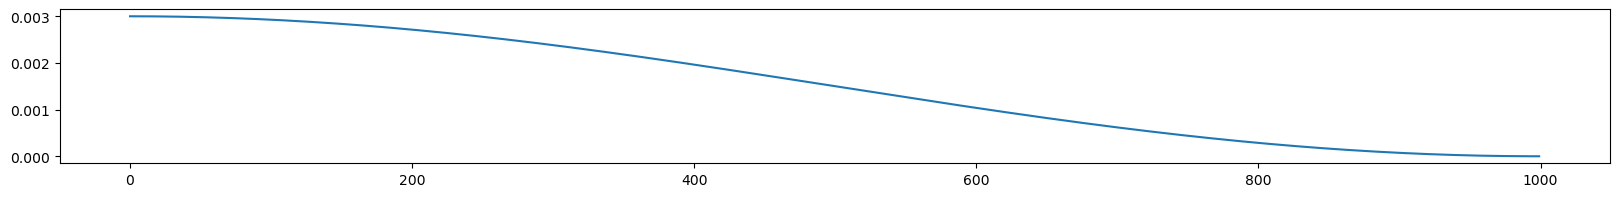

In [15]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [16]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [17]:
run(0)
run(1)
run(2)
run(3)
run(4)

164 42
Sat Aug 26 07:00:57 2023 Epoch: 1


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.3683688341372682
Sat Aug 26 07:01:31 2023 Fold 0, Epoch 1, lr: 0.0030000, train loss: -101.16443, valid loss: -351.33680, metric: 1.368369.
metric_best (0.000000 --> 1.368369). Saving model ...
Sat Aug 26 07:01:32 2023 Epoch: 2


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.4017413530349387
Sat Aug 26 07:01:56 2023 Fold 0, Epoch 2, lr: 0.0030000, train loss: -447.78931, valid loss: -1190.70743, metric: 1.401741.
metric_best (1.368369 --> 1.401741). Saving model ...
Sat Aug 26 07:01:57 2023 Epoch: 3


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.3546961861071154
Sat Aug 26 07:02:21 2023 Fold 0, Epoch 3, lr: 0.0030000, train loss: -1075.99225, valid loss: -1164.13797, metric: 1.354696.
Sat Aug 26 07:02:21 2023 Epoch: 4


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1557458999695402
Sat Aug 26 07:02:46 2023 Fold 0, Epoch 4, lr: 0.0029999, train loss: -1977.15481, valid loss: -3480.79119, metric: 1.155746.
Sat Aug 26 07:02:46 2023 Epoch: 5


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1218323517923199
Sat Aug 26 07:03:10 2023 Fold 0, Epoch 5, lr: 0.0029999, train loss: -3209.80482, valid loss: -3113.56534, metric: 1.121832.
Sat Aug 26 07:03:10 2023 Epoch: 6


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:03:35 2023 Fold 0, Epoch 6, lr: 0.0029998, train loss: -4789.61669, valid loss: -8168.25049, metric: 1.105305.
Sat Aug 26 07:03:35 2023 Epoch: 7


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:04:00 2023 Fold 0, Epoch 7, lr: 0.0029997, train loss: -6682.52338, valid loss: -5381.03034, metric: 1.105305.
Sat Aug 26 07:04:00 2023 Epoch: 8


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:04:24 2023 Fold 0, Epoch 8, lr: 0.0029996, train loss: -8913.25157, valid loss: -6389.77559, metric: 1.105305.
Sat Aug 26 07:04:24 2023 Epoch: 9


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1437242322206114
Sat Aug 26 07:04:49 2023 Fold 0, Epoch 9, lr: 0.0029995, train loss: -11421.18756, valid loss: -10079.14236, metric: 1.143724.
Sat Aug 26 07:04:49 2023 Epoch: 10


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:05:13 2023 Fold 0, Epoch 10, lr: 0.0029994, train loss: -13852.71383, valid loss: -19238.50746, metric: 1.105305.
Sat Aug 26 07:05:14 2023 Epoch: 11


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:05:38 2023 Fold 0, Epoch 11, lr: 0.0029993, train loss: -17617.32465, valid loss: -22922.76820, metric: 1.105305.
Sat Aug 26 07:05:38 2023 Epoch: 12


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:06:02 2023 Fold 0, Epoch 12, lr: 0.0029991, train loss: -20188.49981, valid loss: -24120.88885, metric: 1.105305.
Sat Aug 26 07:06:03 2023 Epoch: 13


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:06:27 2023 Fold 0, Epoch 13, lr: 0.0029989, train loss: -23810.28644, valid loss: -23939.98455, metric: 1.105305.
Sat Aug 26 07:06:27 2023 Epoch: 14


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:06:52 2023 Fold 0, Epoch 14, lr: 0.0029987, train loss: -27588.57470, valid loss: -32180.70934, metric: 1.105305.
Sat Aug 26 07:06:52 2023 Epoch: 15


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:07:16 2023 Fold 0, Epoch 15, lr: 0.0029985, train loss: nan, valid loss: -44840.21946, metric: 1.105305.
Sat Aug 26 07:07:17 2023 Epoch: 16


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:07:41 2023 Fold 0, Epoch 16, lr: 0.0029983, train loss: nan, valid loss: -33851.45534, metric: 1.105305.
Sat Aug 26 07:07:41 2023 Epoch: 17


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:08:05 2023 Fold 0, Epoch 17, lr: 0.0029981, train loss: nan, valid loss: -43725.52379, metric: 1.105305.
Sat Aug 26 07:08:06 2023 Epoch: 18


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:08:30 2023 Fold 0, Epoch 18, lr: 0.0029979, train loss: nan, valid loss: -46039.86062, metric: 1.105305.
Sat Aug 26 07:08:30 2023 Epoch: 19


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:08:54 2023 Fold 0, Epoch 19, lr: 0.0029976, train loss: nan, valid loss: -54668.46911, metric: 1.105305.
Sat Aug 26 07:08:55 2023 Epoch: 20


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:09:19 2023 Fold 0, Epoch 20, lr: 0.0029973, train loss: nan, valid loss: -68092.94070, metric: 1.105305.
Sat Aug 26 07:09:19 2023 Epoch: 21


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:09:44 2023 Fold 0, Epoch 21, lr: 0.0029970, train loss: nan, valid loss: -69598.81534, metric: 1.105305.
Sat Aug 26 07:09:44 2023 Epoch: 22


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:10:08 2023 Fold 0, Epoch 22, lr: 0.0029967, train loss: nan, valid loss: -68097.52628, metric: 1.105305.
Sat Aug 26 07:10:08 2023 Epoch: 23


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:10:33 2023 Fold 0, Epoch 23, lr: 0.0029964, train loss: nan, valid loss: -70074.73224, metric: 1.105305.
Sat Aug 26 07:10:33 2023 Epoch: 24


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:10:57 2023 Fold 0, Epoch 24, lr: 0.0029961, train loss: nan, valid loss: -80370.76207, metric: 1.105305.
Sat Aug 26 07:10:57 2023 Epoch: 25


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:11:22 2023 Fold 0, Epoch 25, lr: 0.0029957, train loss: nan, valid loss: -85270.46058, metric: 1.105305.
Sat Aug 26 07:11:22 2023 Epoch: 26


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:11:46 2023 Fold 0, Epoch 26, lr: 0.0029954, train loss: nan, valid loss: -95671.25249, metric: 1.105305.
Sat Aug 26 07:11:46 2023 Epoch: 27


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:12:10 2023 Fold 0, Epoch 27, lr: 0.0029950, train loss: nan, valid loss: -112607.86896, metric: 1.105305.
Sat Aug 26 07:12:11 2023 Epoch: 28


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:12:35 2023 Fold 0, Epoch 28, lr: 0.0029946, train loss: nan, valid loss: -111972.60298, metric: 1.105305.
Sat Aug 26 07:12:35 2023 Epoch: 29


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:12:59 2023 Fold 0, Epoch 29, lr: 0.0029942, train loss: nan, valid loss: -116043.66193, metric: 1.105305.
Sat Aug 26 07:13:00 2023 Epoch: 30


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:13:24 2023 Fold 0, Epoch 30, lr: 0.0029938, train loss: nan, valid loss: -135212.27557, metric: 1.105305.
Sat Aug 26 07:13:24 2023 Epoch: 31


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:13:48 2023 Fold 0, Epoch 31, lr: 0.0029933, train loss: nan, valid loss: -110677.90980, metric: 1.105305.
Sat Aug 26 07:13:48 2023 Epoch: 32


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:14:13 2023 Fold 0, Epoch 32, lr: 0.0029929, train loss: nan, valid loss: -128041.65554, metric: 1.105305.
Sat Aug 26 07:14:13 2023 Epoch: 33


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:14:37 2023 Fold 0, Epoch 33, lr: 0.0029924, train loss: nan, valid loss: -141690.46023, metric: 1.105305.
Sat Aug 26 07:14:37 2023 Epoch: 34


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:15:01 2023 Fold 0, Epoch 34, lr: 0.0029919, train loss: nan, valid loss: -151212.93324, metric: 1.105305.
Sat Aug 26 07:15:02 2023 Epoch: 35


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:15:26 2023 Fold 0, Epoch 35, lr: 0.0029915, train loss: nan, valid loss: -153627.94034, metric: 1.105305.
Sat Aug 26 07:15:26 2023 Epoch: 36


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:15:50 2023 Fold 0, Epoch 36, lr: 0.0029909, train loss: nan, valid loss: -205715.80540, metric: 1.105305.
Sat Aug 26 07:15:50 2023 Epoch: 37


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:16:15 2023 Fold 0, Epoch 37, lr: 0.0029904, train loss: nan, valid loss: -179593.33665, metric: 1.105305.
Sat Aug 26 07:16:15 2023 Epoch: 38


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:16:39 2023 Fold 0, Epoch 38, lr: 0.0029899, train loss: nan, valid loss: -240248.10938, metric: 1.105305.
Sat Aug 26 07:16:40 2023 Epoch: 39


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:17:04 2023 Fold 0, Epoch 39, lr: 0.0029893, train loss: nan, valid loss: -235715.32244, metric: 1.105305.
Sat Aug 26 07:17:04 2023 Epoch: 40


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:17:28 2023 Fold 0, Epoch 40, lr: 0.0029888, train loss: nan, valid loss: -229575.74858, metric: 1.105305.
Sat Aug 26 07:17:28 2023 Epoch: 41


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:17:53 2023 Fold 0, Epoch 41, lr: 0.0029882, train loss: nan, valid loss: -227360.90909, metric: 1.105305.
Sat Aug 26 07:17:53 2023 Epoch: 42


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:18:17 2023 Fold 0, Epoch 42, lr: 0.0029876, train loss: nan, valid loss: -219882.30114, metric: 1.105305.
Sat Aug 26 07:18:17 2023 Epoch: 43


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:18:41 2023 Fold 0, Epoch 43, lr: 0.0029870, train loss: nan, valid loss: -209563.74716, metric: 1.105305.
Sat Aug 26 07:18:42 2023 Epoch: 44


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:19:06 2023 Fold 0, Epoch 44, lr: 0.0029863, train loss: nan, valid loss: -261753.79830, metric: 1.105305.
Sat Aug 26 07:19:06 2023 Epoch: 45


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:19:30 2023 Fold 0, Epoch 45, lr: 0.0029857, train loss: nan, valid loss: -270477.35795, metric: 1.105305.
Sat Aug 26 07:19:31 2023 Epoch: 46


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:19:55 2023 Fold 0, Epoch 46, lr: 0.0029850, train loss: nan, valid loss: -257377.68750, metric: 1.105305.
Sat Aug 26 07:19:55 2023 Epoch: 47


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:20:19 2023 Fold 0, Epoch 47, lr: 0.0029844, train loss: nan, valid loss: -267883.64915, metric: 1.105305.
Sat Aug 26 07:20:19 2023 Epoch: 48


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:20:44 2023 Fold 0, Epoch 48, lr: 0.0029837, train loss: nan, valid loss: -271153.53693, metric: 1.105305.
Sat Aug 26 07:20:44 2023 Epoch: 49


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:21:08 2023 Fold 0, Epoch 49, lr: 0.0029830, train loss: nan, valid loss: -274359.49432, metric: 1.105305.
Sat Aug 26 07:21:08 2023 Epoch: 50


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:21:32 2023 Fold 0, Epoch 50, lr: 0.0029823, train loss: nan, valid loss: -323241.61790, metric: 1.105305.
Sat Aug 26 07:21:33 2023 Epoch: 51


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:21:57 2023 Fold 0, Epoch 51, lr: 0.0029815, train loss: nan, valid loss: -393640.04830, metric: 1.105305.
Sat Aug 26 07:21:57 2023 Epoch: 52


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:22:21 2023 Fold 0, Epoch 52, lr: 0.0029808, train loss: nan, valid loss: -358768.07670, metric: 1.105305.
Sat Aug 26 07:22:22 2023 Epoch: 53


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:22:46 2023 Fold 0, Epoch 53, lr: 0.0029800, train loss: nan, valid loss: -350672.00710, metric: 1.105305.
Sat Aug 26 07:22:46 2023 Epoch: 54


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:23:10 2023 Fold 0, Epoch 54, lr: 0.0029793, train loss: nan, valid loss: -331565.17045, metric: 1.105305.
Sat Aug 26 07:23:10 2023 Epoch: 55


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:23:35 2023 Fold 0, Epoch 55, lr: 0.0029785, train loss: nan, valid loss: -386497.72869, metric: 1.105305.
Sat Aug 26 07:23:35 2023 Epoch: 56


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:23:59 2023 Fold 0, Epoch 56, lr: 0.0029777, train loss: nan, valid loss: -394437.32955, metric: 1.105305.
Sat Aug 26 07:23:59 2023 Epoch: 57


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:24:24 2023 Fold 0, Epoch 57, lr: 0.0029768, train loss: nan, valid loss: -392756.37500, metric: 1.105305.
Sat Aug 26 07:24:24 2023 Epoch: 58


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:24:48 2023 Fold 0, Epoch 58, lr: 0.0029760, train loss: nan, valid loss: -405134.89773, metric: 1.105305.
Sat Aug 26 07:24:48 2023 Epoch: 59


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:25:13 2023 Fold 0, Epoch 59, lr: 0.0029752, train loss: nan, valid loss: -476768.47727, metric: 1.105305.
Sat Aug 26 07:25:13 2023 Epoch: 60


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:25:37 2023 Fold 0, Epoch 60, lr: 0.0029743, train loss: nan, valid loss: -478026.77557, metric: 1.105305.
Sat Aug 26 07:25:37 2023 Epoch: 61


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:26:01 2023 Fold 0, Epoch 61, lr: 0.0029734, train loss: nan, valid loss: -535715.46023, metric: 1.105305.
Sat Aug 26 07:26:02 2023 Epoch: 62


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:26:26 2023 Fold 0, Epoch 62, lr: 0.0029725, train loss: nan, valid loss: -453696.73864, metric: 1.105305.
Sat Aug 26 07:26:26 2023 Epoch: 63


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:26:50 2023 Fold 0, Epoch 63, lr: 0.0029716, train loss: nan, valid loss: -436683.96023, metric: 1.105305.
Sat Aug 26 07:26:51 2023 Epoch: 64


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:27:15 2023 Fold 0, Epoch 64, lr: 0.0029707, train loss: nan, valid loss: -412288.48580, metric: 1.105305.
Sat Aug 26 07:27:15 2023 Epoch: 65


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:27:39 2023 Fold 0, Epoch 65, lr: 0.0029698, train loss: nan, valid loss: -516155.66477, metric: 1.105305.
Sat Aug 26 07:27:39 2023 Epoch: 66


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:28:04 2023 Fold 0, Epoch 66, lr: 0.0029688, train loss: nan, valid loss: -490299.56250, metric: 1.105305.
Sat Aug 26 07:28:04 2023 Epoch: 67


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:28:28 2023 Fold 0, Epoch 67, lr: 0.0029679, train loss: nan, valid loss: -574671.50000, metric: 1.105305.
Sat Aug 26 07:28:28 2023 Epoch: 68


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:28:52 2023 Fold 0, Epoch 68, lr: 0.0029669, train loss: nan, valid loss: -576261.08523, metric: 1.105305.
Sat Aug 26 07:28:53 2023 Epoch: 69


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:29:17 2023 Fold 0, Epoch 69, lr: 0.0029659, train loss: nan, valid loss: -567817.99148, metric: 1.105305.
Sat Aug 26 07:29:17 2023 Epoch: 70


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:29:41 2023 Fold 0, Epoch 70, lr: 0.0029649, train loss: nan, valid loss: -550520.90909, metric: 1.105305.
Sat Aug 26 07:29:42 2023 Epoch: 71


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:30:06 2023 Fold 0, Epoch 71, lr: 0.0029639, train loss: nan, valid loss: -608285.45739, metric: 1.105305.
Sat Aug 26 07:30:06 2023 Epoch: 72


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:30:30 2023 Fold 0, Epoch 72, lr: 0.0029628, train loss: nan, valid loss: -585304.74148, metric: 1.105305.
Sat Aug 26 07:30:30 2023 Epoch: 73


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:30:54 2023 Fold 0, Epoch 73, lr: 0.0029618, train loss: nan, valid loss: -591485.16761, metric: 1.105305.
Sat Aug 26 07:30:55 2023 Epoch: 74


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:31:19 2023 Fold 0, Epoch 74, lr: 0.0029607, train loss: nan, valid loss: -646123.60795, metric: 1.105305.
Sat Aug 26 07:31:19 2023 Epoch: 75


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:31:44 2023 Fold 0, Epoch 75, lr: 0.0029596, train loss: nan, valid loss: -589723.91477, metric: 1.105305.
Sat Aug 26 07:31:44 2023 Epoch: 76


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:32:08 2023 Fold 0, Epoch 76, lr: 0.0029586, train loss: nan, valid loss: -671803.88920, metric: 1.105305.
Sat Aug 26 07:32:08 2023 Epoch: 77


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:32:33 2023 Fold 0, Epoch 77, lr: 0.0029574, train loss: nan, valid loss: -658675.25568, metric: 1.105305.
Sat Aug 26 07:32:33 2023 Epoch: 78


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:32:57 2023 Fold 0, Epoch 78, lr: 0.0029563, train loss: nan, valid loss: -644452.73011, metric: 1.105305.
Sat Aug 26 07:32:58 2023 Epoch: 79


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:33:22 2023 Fold 0, Epoch 79, lr: 0.0029552, train loss: nan, valid loss: -729918.77557, metric: 1.105305.
Sat Aug 26 07:33:22 2023 Epoch: 80


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:33:46 2023 Fold 0, Epoch 80, lr: 0.0029540, train loss: nan, valid loss: -646722.51989, metric: 1.105305.
Sat Aug 26 07:33:46 2023 Epoch: 81


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:34:11 2023 Fold 0, Epoch 81, lr: 0.0029529, train loss: nan, valid loss: -736095.51989, metric: 1.105305.
Sat Aug 26 07:34:11 2023 Epoch: 82


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:34:35 2023 Fold 0, Epoch 82, lr: 0.0029517, train loss: nan, valid loss: -770400.10795, metric: 1.105305.
Sat Aug 26 07:34:35 2023 Epoch: 83


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:35:00 2023 Fold 0, Epoch 83, lr: 0.0029505, train loss: nan, valid loss: -767427.61932, metric: 1.105305.
Sat Aug 26 07:35:00 2023 Epoch: 84


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:35:24 2023 Fold 0, Epoch 84, lr: 0.0029493, train loss: nan, valid loss: -775028.07102, metric: 1.105305.
Sat Aug 26 07:35:25 2023 Epoch: 85


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:35:49 2023 Fold 0, Epoch 85, lr: 0.0029481, train loss: nan, valid loss: -802590.75852, metric: 1.105305.
Sat Aug 26 07:35:49 2023 Epoch: 86


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:36:13 2023 Fold 0, Epoch 86, lr: 0.0029468, train loss: nan, valid loss: -765717.86932, metric: 1.105305.
Sat Aug 26 07:36:14 2023 Epoch: 87


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:36:38 2023 Fold 0, Epoch 87, lr: 0.0029456, train loss: nan, valid loss: -821413.36648, metric: 1.105305.
Sat Aug 26 07:36:38 2023 Epoch: 88


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:37:02 2023 Fold 0, Epoch 88, lr: 0.0029443, train loss: nan, valid loss: -759064.86932, metric: 1.105305.
Sat Aug 26 07:37:02 2023 Epoch: 89


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:37:27 2023 Fold 0, Epoch 89, lr: 0.0029430, train loss: nan, valid loss: -964443.33523, metric: 1.105305.
Sat Aug 26 07:37:27 2023 Epoch: 90


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:37:51 2023 Fold 0, Epoch 90, lr: 0.0029417, train loss: nan, valid loss: -819694.02273, metric: 1.105305.
Sat Aug 26 07:37:51 2023 Epoch: 91


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:38:16 2023 Fold 0, Epoch 91, lr: 0.0029404, train loss: nan, valid loss: -859500.85795, metric: 1.105305.
Sat Aug 26 07:38:16 2023 Epoch: 92


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:38:40 2023 Fold 0, Epoch 92, lr: 0.0029391, train loss: nan, valid loss: -864159.50568, metric: 1.105305.
Sat Aug 26 07:38:41 2023 Epoch: 93


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:39:05 2023 Fold 0, Epoch 93, lr: 0.0029378, train loss: nan, valid loss: -936794.51705, metric: 1.105305.
Sat Aug 26 07:39:05 2023 Epoch: 94


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:39:29 2023 Fold 0, Epoch 94, lr: 0.0029364, train loss: nan, valid loss: -874379.51989, metric: 1.105305.
Sat Aug 26 07:39:30 2023 Epoch: 95


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:39:54 2023 Fold 0, Epoch 95, lr: 0.0029351, train loss: nan, valid loss: -775157.43750, metric: 1.105305.
Sat Aug 26 07:39:54 2023 Epoch: 96


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:40:18 2023 Fold 0, Epoch 96, lr: 0.0029337, train loss: nan, valid loss: -1013559.78977, metric: 1.105305.
Sat Aug 26 07:40:18 2023 Epoch: 97


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:40:43 2023 Fold 0, Epoch 97, lr: 0.0029323, train loss: nan, valid loss: -905615.03977, metric: 1.105305.
Sat Aug 26 07:40:43 2023 Epoch: 98


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:41:07 2023 Fold 0, Epoch 98, lr: 0.0029309, train loss: nan, valid loss: -1046481.50000, metric: 1.105305.
Sat Aug 26 07:41:08 2023 Epoch: 99


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:41:32 2023 Fold 0, Epoch 99, lr: 0.0029295, train loss: nan, valid loss: -965721.98295, metric: 1.105305.
Sat Aug 26 07:41:32 2023 Epoch: 100


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:41:56 2023 Fold 0, Epoch 100, lr: 0.0029280, train loss: nan, valid loss: -1078371.98295, metric: 1.105305.
Sat Aug 26 07:41:57 2023 Epoch: 101


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:42:21 2023 Fold 0, Epoch 101, lr: 0.0029266, train loss: nan, valid loss: -1012406.40909, metric: 1.105305.
Sat Aug 26 07:42:21 2023 Epoch: 102


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:42:45 2023 Fold 0, Epoch 102, lr: 0.0029251, train loss: nan, valid loss: -1050333.45455, metric: 1.105305.
Sat Aug 26 07:42:46 2023 Epoch: 103


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:43:10 2023 Fold 0, Epoch 103, lr: 0.0029236, train loss: nan, valid loss: -1168700.43182, metric: 1.105305.
Sat Aug 26 07:43:10 2023 Epoch: 104


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:43:35 2023 Fold 0, Epoch 104, lr: 0.0029222, train loss: nan, valid loss: -991653.32386, metric: 1.105305.
Sat Aug 26 07:43:35 2023 Epoch: 105


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:43:59 2023 Fold 0, Epoch 105, lr: 0.0029206, train loss: nan, valid loss: -1115668.67614, metric: 1.105305.
Sat Aug 26 07:43:59 2023 Epoch: 106


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:44:23 2023 Fold 0, Epoch 106, lr: 0.0029191, train loss: nan, valid loss: -1167535.88068, metric: 1.105305.
Sat Aug 26 07:44:23 2023 Epoch: 107


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:44:48 2023 Fold 0, Epoch 107, lr: 0.0029176, train loss: nan, valid loss: -1178550.97727, metric: 1.105305.
Sat Aug 26 07:44:48 2023 Epoch: 108


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:45:12 2023 Fold 0, Epoch 108, lr: 0.0029160, train loss: nan, valid loss: -1162048.48295, metric: 1.105305.
Sat Aug 26 07:45:12 2023 Epoch: 109


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:45:36 2023 Fold 0, Epoch 109, lr: 0.0029145, train loss: nan, valid loss: -1165600.26136, metric: 1.105305.
Sat Aug 26 07:45:37 2023 Epoch: 110


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:46:01 2023 Fold 0, Epoch 110, lr: 0.0029129, train loss: nan, valid loss: -1191819.47727, metric: 1.105305.
Sat Aug 26 07:46:01 2023 Epoch: 111


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:46:25 2023 Fold 0, Epoch 111, lr: 0.0029113, train loss: nan, valid loss: -1230166.75000, metric: 1.105305.
Sat Aug 26 07:46:26 2023 Epoch: 112


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:46:50 2023 Fold 0, Epoch 112, lr: 0.0029097, train loss: nan, valid loss: -1233479.94318, metric: 1.105305.
Sat Aug 26 07:46:50 2023 Epoch: 113


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:47:14 2023 Fold 0, Epoch 113, lr: 0.0029081, train loss: nan, valid loss: -1255652.72727, metric: 1.105305.
Sat Aug 26 07:47:15 2023 Epoch: 114


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:47:39 2023 Fold 0, Epoch 114, lr: 0.0029065, train loss: nan, valid loss: -1373466.57955, metric: 1.105305.
Sat Aug 26 07:47:39 2023 Epoch: 115


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:48:03 2023 Fold 0, Epoch 115, lr: 0.0029048, train loss: nan, valid loss: -1199440.60227, metric: 1.105305.
Sat Aug 26 07:48:04 2023 Epoch: 116


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:48:28 2023 Fold 0, Epoch 116, lr: 0.0029032, train loss: nan, valid loss: -1295749.72727, metric: 1.105305.
Sat Aug 26 07:48:28 2023 Epoch: 117


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:48:52 2023 Fold 0, Epoch 117, lr: 0.0029015, train loss: nan, valid loss: -1322380.82955, metric: 1.105305.
Sat Aug 26 07:48:53 2023 Epoch: 118


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:49:17 2023 Fold 0, Epoch 118, lr: 0.0028998, train loss: nan, valid loss: -1294085.46023, metric: 1.105305.
Sat Aug 26 07:49:17 2023 Epoch: 119


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:49:41 2023 Fold 0, Epoch 119, lr: 0.0028981, train loss: nan, valid loss: -1383081.65909, metric: 1.105305.
Sat Aug 26 07:49:41 2023 Epoch: 120


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:50:05 2023 Fold 0, Epoch 120, lr: 0.0028964, train loss: nan, valid loss: -1339780.97159, metric: 1.105305.
Sat Aug 26 07:50:06 2023 Epoch: 121


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:50:30 2023 Fold 0, Epoch 121, lr: 0.0028947, train loss: nan, valid loss: -1337420.60795, metric: 1.105305.
Sat Aug 26 07:50:30 2023 Epoch: 122


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:50:54 2023 Fold 0, Epoch 122, lr: 0.0028929, train loss: nan, valid loss: -1318959.28977, metric: 1.105305.
Sat Aug 26 07:50:55 2023 Epoch: 123


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:51:19 2023 Fold 0, Epoch 123, lr: 0.0028912, train loss: nan, valid loss: -1428809.01705, metric: 1.105305.
Sat Aug 26 07:51:19 2023 Epoch: 124


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:51:43 2023 Fold 0, Epoch 124, lr: 0.0028894, train loss: nan, valid loss: -1289426.33523, metric: 1.105305.
Sat Aug 26 07:51:43 2023 Epoch: 125


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:52:08 2023 Fold 0, Epoch 125, lr: 0.0028876, train loss: nan, valid loss: -1556219.44318, metric: 1.105305.
Sat Aug 26 07:52:08 2023 Epoch: 126


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:52:32 2023 Fold 0, Epoch 126, lr: 0.0028858, train loss: nan, valid loss: -1517354.35227, metric: 1.105305.
Sat Aug 26 07:52:32 2023 Epoch: 127


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:52:57 2023 Fold 0, Epoch 127, lr: 0.0028840, train loss: nan, valid loss: -1522780.31250, metric: 1.105305.
Sat Aug 26 07:52:57 2023 Epoch: 128


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:53:21 2023 Fold 0, Epoch 128, lr: 0.0028822, train loss: nan, valid loss: -1490901.98295, metric: 1.105305.
Sat Aug 26 07:53:21 2023 Epoch: 129


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:53:46 2023 Fold 0, Epoch 129, lr: 0.0028803, train loss: nan, valid loss: -1504618.42614, metric: 1.105305.
Sat Aug 26 07:53:46 2023 Epoch: 130


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:54:10 2023 Fold 0, Epoch 130, lr: 0.0028785, train loss: nan, valid loss: -1489245.58523, metric: 1.105305.
Sat Aug 26 07:54:10 2023 Epoch: 131


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:54:35 2023 Fold 0, Epoch 131, lr: 0.0028766, train loss: nan, valid loss: -1586859.70455, metric: 1.105305.
Sat Aug 26 07:54:35 2023 Epoch: 132


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:54:59 2023 Fold 0, Epoch 132, lr: 0.0028748, train loss: nan, valid loss: -1424048.39773, metric: 1.105305.
Sat Aug 26 07:54:59 2023 Epoch: 133


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:55:24 2023 Fold 0, Epoch 133, lr: 0.0028729, train loss: nan, valid loss: -1650673.81818, metric: 1.105305.
Sat Aug 26 07:55:24 2023 Epoch: 134


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:55:48 2023 Fold 0, Epoch 134, lr: 0.0028710, train loss: nan, valid loss: -1701335.37500, metric: 1.105305.
Sat Aug 26 07:55:49 2023 Epoch: 135


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:56:13 2023 Fold 0, Epoch 135, lr: 0.0028690, train loss: nan, valid loss: -1618563.55682, metric: 1.105305.
Sat Aug 26 07:56:13 2023 Epoch: 136


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:56:37 2023 Fold 0, Epoch 136, lr: 0.0028671, train loss: nan, valid loss: -1611880.93750, metric: 1.105305.
Sat Aug 26 07:56:37 2023 Epoch: 137


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:57:02 2023 Fold 0, Epoch 137, lr: 0.0028652, train loss: nan, valid loss: -1733959.81250, metric: 1.105305.
Sat Aug 26 07:57:02 2023 Epoch: 138


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:57:26 2023 Fold 0, Epoch 138, lr: 0.0028632, train loss: nan, valid loss: -1676916.22727, metric: 1.105305.
Sat Aug 26 07:57:26 2023 Epoch: 139


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:57:51 2023 Fold 0, Epoch 139, lr: 0.0028612, train loss: nan, valid loss: -1764233.09091, metric: 1.105305.
Sat Aug 26 07:57:51 2023 Epoch: 140


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:58:15 2023 Fold 0, Epoch 140, lr: 0.0028592, train loss: nan, valid loss: -1638608.25000, metric: 1.105305.
Sat Aug 26 07:58:15 2023 Epoch: 141


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:58:40 2023 Fold 0, Epoch 141, lr: 0.0028572, train loss: nan, valid loss: -1813619.67045, metric: 1.105305.
Sat Aug 26 07:58:40 2023 Epoch: 142


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:59:04 2023 Fold 0, Epoch 142, lr: 0.0028552, train loss: nan, valid loss: -1725652.64773, metric: 1.105305.
Sat Aug 26 07:59:04 2023 Epoch: 143


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:59:29 2023 Fold 0, Epoch 143, lr: 0.0028532, train loss: nan, valid loss: -1730771.89773, metric: 1.105305.
Sat Aug 26 07:59:29 2023 Epoch: 144


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 07:59:53 2023 Fold 0, Epoch 144, lr: 0.0028512, train loss: nan, valid loss: -1754271.93182, metric: 1.105305.
Sat Aug 26 07:59:53 2023 Epoch: 145


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:00:17 2023 Fold 0, Epoch 145, lr: 0.0028491, train loss: nan, valid loss: -1821276.14773, metric: 1.105305.
Sat Aug 26 08:00:18 2023 Epoch: 146


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:00:42 2023 Fold 0, Epoch 146, lr: 0.0028470, train loss: nan, valid loss: -1770311.35227, metric: 1.105305.
Sat Aug 26 08:00:42 2023 Epoch: 147


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:01:06 2023 Fold 0, Epoch 147, lr: 0.0028450, train loss: nan, valid loss: -1889033.95455, metric: 1.105305.
Sat Aug 26 08:01:07 2023 Epoch: 148


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:01:31 2023 Fold 0, Epoch 148, lr: 0.0028429, train loss: nan, valid loss: -1956074.39773, metric: 1.105305.
Sat Aug 26 08:01:31 2023 Epoch: 149


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:01:55 2023 Fold 0, Epoch 149, lr: 0.0028408, train loss: nan, valid loss: -1938165.65909, metric: 1.105305.
Sat Aug 26 08:01:55 2023 Epoch: 150


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:02:19 2023 Fold 0, Epoch 150, lr: 0.0028386, train loss: nan, valid loss: -1918478.70455, metric: 1.105305.
Sat Aug 26 08:02:20 2023 Epoch: 151


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:02:44 2023 Fold 0, Epoch 151, lr: 0.0028365, train loss: nan, valid loss: -1895277.10227, metric: 1.105305.
Sat Aug 26 08:02:44 2023 Epoch: 152


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:03:08 2023 Fold 0, Epoch 152, lr: 0.0028344, train loss: nan, valid loss: -1830365.20455, metric: 1.105305.
Sat Aug 26 08:03:08 2023 Epoch: 153


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:03:32 2023 Fold 0, Epoch 153, lr: 0.0028322, train loss: nan, valid loss: -1908691.04545, metric: 1.105305.
Sat Aug 26 08:03:33 2023 Epoch: 154


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:03:57 2023 Fold 0, Epoch 154, lr: 0.0028300, train loss: nan, valid loss: -1950852.47727, metric: 1.105305.
Sat Aug 26 08:03:57 2023 Epoch: 155


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:04:21 2023 Fold 0, Epoch 155, lr: 0.0028278, train loss: nan, valid loss: -1990122.20455, metric: 1.105305.
Sat Aug 26 08:04:22 2023 Epoch: 156


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:04:46 2023 Fold 0, Epoch 156, lr: 0.0028256, train loss: nan, valid loss: -1916933.61364, metric: 1.105305.
Sat Aug 26 08:04:46 2023 Epoch: 157


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:05:10 2023 Fold 0, Epoch 157, lr: 0.0028234, train loss: nan, valid loss: -1958313.72727, metric: 1.105305.
Sat Aug 26 08:05:10 2023 Epoch: 158


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:05:35 2023 Fold 0, Epoch 158, lr: 0.0028212, train loss: nan, valid loss: -2200969.53409, metric: 1.105305.
Sat Aug 26 08:05:35 2023 Epoch: 159


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:05:59 2023 Fold 0, Epoch 159, lr: 0.0028190, train loss: nan, valid loss: -1766922.62500, metric: 1.105305.
Sat Aug 26 08:05:59 2023 Epoch: 160


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:06:23 2023 Fold 0, Epoch 160, lr: 0.0028167, train loss: nan, valid loss: -2132415.13636, metric: 1.105305.
Sat Aug 26 08:06:24 2023 Epoch: 161


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:06:48 2023 Fold 0, Epoch 161, lr: 0.0028145, train loss: nan, valid loss: -2257648.89773, metric: 1.105305.
Sat Aug 26 08:06:48 2023 Epoch: 162


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:07:12 2023 Fold 0, Epoch 162, lr: 0.0028122, train loss: nan, valid loss: -1998675.19318, metric: 1.105305.
Sat Aug 26 08:07:13 2023 Epoch: 163


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:07:37 2023 Fold 0, Epoch 163, lr: 0.0028099, train loss: nan, valid loss: -2133643.15909, metric: 1.105305.
Sat Aug 26 08:07:37 2023 Epoch: 164


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:08:01 2023 Fold 0, Epoch 164, lr: 0.0028076, train loss: nan, valid loss: -2021681.86364, metric: 1.105305.
Sat Aug 26 08:08:01 2023 Epoch: 165


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:08:26 2023 Fold 0, Epoch 165, lr: 0.0028053, train loss: nan, valid loss: -2282498.21591, metric: 1.105305.
Sat Aug 26 08:08:26 2023 Epoch: 166


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:08:50 2023 Fold 0, Epoch 166, lr: 0.0028029, train loss: nan, valid loss: -2145364.90909, metric: 1.105305.
Sat Aug 26 08:08:50 2023 Epoch: 167


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:09:14 2023 Fold 0, Epoch 167, lr: 0.0028006, train loss: nan, valid loss: -2250101.90909, metric: 1.105305.
Sat Aug 26 08:09:15 2023 Epoch: 168


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:09:39 2023 Fold 0, Epoch 168, lr: 0.0027983, train loss: nan, valid loss: -2061534.73864, metric: 1.105305.
Sat Aug 26 08:09:39 2023 Epoch: 169


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:10:03 2023 Fold 0, Epoch 169, lr: 0.0027959, train loss: nan, valid loss: -2075307.39773, metric: 1.105305.
Sat Aug 26 08:10:03 2023 Epoch: 170


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:10:28 2023 Fold 0, Epoch 170, lr: 0.0027935, train loss: nan, valid loss: -2291702.79545, metric: 1.105305.
Sat Aug 26 08:10:28 2023 Epoch: 171


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:10:52 2023 Fold 0, Epoch 171, lr: 0.0027911, train loss: nan, valid loss: -2219834.44318, metric: 1.105305.
Sat Aug 26 08:10:52 2023 Epoch: 172


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:11:16 2023 Fold 0, Epoch 172, lr: 0.0027887, train loss: nan, valid loss: -2250540.97727, metric: 1.105305.
Sat Aug 26 08:11:17 2023 Epoch: 173


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:11:41 2023 Fold 0, Epoch 173, lr: 0.0027863, train loss: nan, valid loss: -2284751.27273, metric: 1.105305.
Sat Aug 26 08:11:41 2023 Epoch: 174


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:12:05 2023 Fold 0, Epoch 174, lr: 0.0027839, train loss: nan, valid loss: -2433774.02273, metric: 1.105305.
Sat Aug 26 08:12:05 2023 Epoch: 175


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:12:29 2023 Fold 0, Epoch 175, lr: 0.0027814, train loss: nan, valid loss: -2390574.56818, metric: 1.105305.
Sat Aug 26 08:12:30 2023 Epoch: 176


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:12:54 2023 Fold 0, Epoch 176, lr: 0.0027790, train loss: nan, valid loss: -2309663.12500, metric: 1.105305.
Sat Aug 26 08:12:54 2023 Epoch: 177


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:13:18 2023 Fold 0, Epoch 177, lr: 0.0027765, train loss: nan, valid loss: -2357253.63636, metric: 1.105305.
Sat Aug 26 08:13:19 2023 Epoch: 178


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:13:43 2023 Fold 0, Epoch 178, lr: 0.0027740, train loss: nan, valid loss: -2540451.29545, metric: 1.105305.
Sat Aug 26 08:13:43 2023 Epoch: 179


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:14:07 2023 Fold 0, Epoch 179, lr: 0.0027715, train loss: nan, valid loss: -2486006.47727, metric: 1.105305.
Sat Aug 26 08:14:08 2023 Epoch: 180


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:14:32 2023 Fold 0, Epoch 180, lr: 0.0027690, train loss: nan, valid loss: -2543006.12500, metric: 1.105305.
Sat Aug 26 08:14:32 2023 Epoch: 181


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:14:56 2023 Fold 0, Epoch 181, lr: 0.0027665, train loss: nan, valid loss: -2434612.72727, metric: 1.105305.
Sat Aug 26 08:14:56 2023 Epoch: 182


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:15:21 2023 Fold 0, Epoch 182, lr: 0.0027640, train loss: nan, valid loss: -2390985.34091, metric: 1.105305.
Sat Aug 26 08:15:21 2023 Epoch: 183


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:15:45 2023 Fold 0, Epoch 183, lr: 0.0027614, train loss: nan, valid loss: -2341407.32955, metric: 1.105305.
Sat Aug 26 08:15:45 2023 Epoch: 184


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:16:10 2023 Fold 0, Epoch 184, lr: 0.0027589, train loss: nan, valid loss: -2702596.45455, metric: 1.105305.
Sat Aug 26 08:16:10 2023 Epoch: 185


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:16:34 2023 Fold 0, Epoch 185, lr: 0.0027563, train loss: nan, valid loss: -2383835.88636, metric: 1.105305.
Sat Aug 26 08:16:34 2023 Epoch: 186


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:16:59 2023 Fold 0, Epoch 186, lr: 0.0027537, train loss: nan, valid loss: -2524280.02273, metric: 1.105305.
Sat Aug 26 08:16:59 2023 Epoch: 187


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:17:23 2023 Fold 0, Epoch 187, lr: 0.0027511, train loss: nan, valid loss: -2446307.03409, metric: 1.105305.
Sat Aug 26 08:17:23 2023 Epoch: 188


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:17:47 2023 Fold 0, Epoch 188, lr: 0.0027485, train loss: nan, valid loss: -2625478.68182, metric: 1.105305.
Sat Aug 26 08:17:47 2023 Epoch: 189


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:18:11 2023 Fold 0, Epoch 189, lr: 0.0027459, train loss: nan, valid loss: -2544643.51136, metric: 1.105305.
Sat Aug 26 08:18:12 2023 Epoch: 190


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:18:36 2023 Fold 0, Epoch 190, lr: 0.0027433, train loss: nan, valid loss: -2561943.07955, metric: 1.105305.
Sat Aug 26 08:18:36 2023 Epoch: 191


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:19:00 2023 Fold 0, Epoch 191, lr: 0.0027406, train loss: nan, valid loss: -2652254.92045, metric: 1.105305.
Sat Aug 26 08:19:01 2023 Epoch: 192


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:19:25 2023 Fold 0, Epoch 192, lr: 0.0027380, train loss: nan, valid loss: -2621694.97727, metric: 1.105305.
Sat Aug 26 08:19:25 2023 Epoch: 193


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:19:49 2023 Fold 0, Epoch 193, lr: 0.0027353, train loss: nan, valid loss: -2675936.44318, metric: 1.105305.
Sat Aug 26 08:19:50 2023 Epoch: 194


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:20:14 2023 Fold 0, Epoch 194, lr: 0.0027326, train loss: nan, valid loss: -2698175.36364, metric: 1.105305.
Sat Aug 26 08:20:14 2023 Epoch: 195


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:20:38 2023 Fold 0, Epoch 195, lr: 0.0027299, train loss: nan, valid loss: -2778405.12500, metric: 1.105305.
Sat Aug 26 08:20:38 2023 Epoch: 196


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:21:02 2023 Fold 0, Epoch 196, lr: 0.0027272, train loss: nan, valid loss: -2695334.42045, metric: 1.105305.
Sat Aug 26 08:21:03 2023 Epoch: 197


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:21:27 2023 Fold 0, Epoch 197, lr: 0.0027245, train loss: nan, valid loss: -2745784.50000, metric: 1.105305.
Sat Aug 26 08:21:27 2023 Epoch: 198


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:21:51 2023 Fold 0, Epoch 198, lr: 0.0027218, train loss: nan, valid loss: -2765200.67045, metric: 1.105305.
Sat Aug 26 08:21:52 2023 Epoch: 199


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:22:16 2023 Fold 0, Epoch 199, lr: 0.0027190, train loss: nan, valid loss: -2681174.17045, metric: 1.105305.
Sat Aug 26 08:22:16 2023 Epoch: 200


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:22:40 2023 Fold 0, Epoch 200, lr: 0.0027163, train loss: nan, valid loss: -2645576.20455, metric: 1.105305.
Sat Aug 26 08:22:40 2023 Epoch: 201


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:23:05 2023 Fold 0, Epoch 201, lr: 0.0027135, train loss: nan, valid loss: -2866538.03409, metric: 1.105305.
Sat Aug 26 08:23:05 2023 Epoch: 202


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:23:29 2023 Fold 0, Epoch 202, lr: 0.0027107, train loss: nan, valid loss: -2962194.95455, metric: 1.105305.
Sat Aug 26 08:23:29 2023 Epoch: 203


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:23:54 2023 Fold 0, Epoch 203, lr: 0.0027080, train loss: nan, valid loss: -2910989.34091, metric: 1.105305.
Sat Aug 26 08:23:54 2023 Epoch: 204


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:24:18 2023 Fold 0, Epoch 204, lr: 0.0027052, train loss: nan, valid loss: -3016505.25000, metric: 1.105305.
Sat Aug 26 08:24:18 2023 Epoch: 205


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:24:42 2023 Fold 0, Epoch 205, lr: 0.0027024, train loss: nan, valid loss: -2917817.28409, metric: 1.105305.
Sat Aug 26 08:24:43 2023 Epoch: 206


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:25:07 2023 Fold 0, Epoch 206, lr: 0.0026995, train loss: nan, valid loss: -2866558.34091, metric: 1.105305.
Sat Aug 26 08:25:07 2023 Epoch: 207


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:25:31 2023 Fold 0, Epoch 207, lr: 0.0026967, train loss: nan, valid loss: -2970906.78409, metric: 1.105305.
Sat Aug 26 08:25:31 2023 Epoch: 208


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:25:56 2023 Fold 0, Epoch 208, lr: 0.0026938, train loss: nan, valid loss: -3092835.46591, metric: 1.105305.
Sat Aug 26 08:25:56 2023 Epoch: 209


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:26:20 2023 Fold 0, Epoch 209, lr: 0.0026910, train loss: nan, valid loss: -2938363.42045, metric: 1.105305.
Sat Aug 26 08:26:20 2023 Epoch: 210


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:26:45 2023 Fold 0, Epoch 210, lr: 0.0026881, train loss: nan, valid loss: -2970873.57955, metric: 1.105305.
Sat Aug 26 08:26:45 2023 Epoch: 211


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:27:09 2023 Fold 0, Epoch 211, lr: 0.0026852, train loss: nan, valid loss: -3062555.75000, metric: 1.105305.
Sat Aug 26 08:27:09 2023 Epoch: 212


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:27:34 2023 Fold 0, Epoch 212, lr: 0.0026823, train loss: nan, valid loss: -3178344.81818, metric: 1.105305.
Sat Aug 26 08:27:34 2023 Epoch: 213


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:27:58 2023 Fold 0, Epoch 213, lr: 0.0026794, train loss: nan, valid loss: -2983189.46591, metric: 1.105305.
Sat Aug 26 08:27:58 2023 Epoch: 214


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:28:22 2023 Fold 0, Epoch 214, lr: 0.0026765, train loss: nan, valid loss: -3046631.65909, metric: 1.105305.
Sat Aug 26 08:28:23 2023 Epoch: 215


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:28:47 2023 Fold 0, Epoch 215, lr: 0.0026736, train loss: nan, valid loss: -3060326.64773, metric: 1.105305.
Sat Aug 26 08:28:47 2023 Epoch: 216


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:29:11 2023 Fold 0, Epoch 216, lr: 0.0026706, train loss: nan, valid loss: -3107637.65909, metric: 1.105305.
Sat Aug 26 08:29:12 2023 Epoch: 217


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:29:36 2023 Fold 0, Epoch 217, lr: 0.0026677, train loss: nan, valid loss: -3099448.70455, metric: 1.105305.
Sat Aug 26 08:29:36 2023 Epoch: 218


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:30:00 2023 Fold 0, Epoch 218, lr: 0.0026647, train loss: nan, valid loss: -3071563.54545, metric: 1.105305.
Sat Aug 26 08:30:00 2023 Epoch: 219


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:30:25 2023 Fold 0, Epoch 219, lr: 0.0026618, train loss: nan, valid loss: -3151268.77273, metric: 1.105305.
Sat Aug 26 08:30:25 2023 Epoch: 220


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:30:49 2023 Fold 0, Epoch 220, lr: 0.0026588, train loss: nan, valid loss: -3280148.75000, metric: 1.105305.
Sat Aug 26 08:30:49 2023 Epoch: 221


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:31:14 2023 Fold 0, Epoch 221, lr: 0.0026558, train loss: nan, valid loss: -3093801.40909, metric: 1.105305.
Sat Aug 26 08:31:14 2023 Epoch: 222


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:31:38 2023 Fold 0, Epoch 222, lr: 0.0026528, train loss: nan, valid loss: -3368907.81818, metric: 1.105305.
Sat Aug 26 08:31:38 2023 Epoch: 223


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:32:02 2023 Fold 0, Epoch 223, lr: 0.0026497, train loss: nan, valid loss: -3477692.02273, metric: 1.105305.
Sat Aug 26 08:32:03 2023 Epoch: 224


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:32:27 2023 Fold 0, Epoch 224, lr: 0.0026467, train loss: nan, valid loss: -3467765.36364, metric: 1.105305.
Sat Aug 26 08:32:27 2023 Epoch: 225


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:32:51 2023 Fold 0, Epoch 225, lr: 0.0026437, train loss: nan, valid loss: -3311488.15909, metric: 1.105305.
Sat Aug 26 08:32:52 2023 Epoch: 226


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:33:16 2023 Fold 0, Epoch 226, lr: 0.0026406, train loss: nan, valid loss: -3466816.63636, metric: 1.105305.
Sat Aug 26 08:33:16 2023 Epoch: 227


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:33:40 2023 Fold 0, Epoch 227, lr: 0.0026375, train loss: nan, valid loss: -3373821.88636, metric: 1.105305.
Sat Aug 26 08:33:41 2023 Epoch: 228


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:34:05 2023 Fold 0, Epoch 228, lr: 0.0026345, train loss: nan, valid loss: -3292418.77273, metric: 1.105305.
Sat Aug 26 08:34:05 2023 Epoch: 229


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:34:29 2023 Fold 0, Epoch 229, lr: 0.0026314, train loss: nan, valid loss: -3454823.18182, metric: 1.105305.
Sat Aug 26 08:34:30 2023 Epoch: 230


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:34:54 2023 Fold 0, Epoch 230, lr: 0.0026283, train loss: nan, valid loss: -3368092.13636, metric: 1.105305.
Sat Aug 26 08:34:54 2023 Epoch: 231


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

best th: 0.2 best dc: 1.1053046764392775
Sat Aug 26 08:35:18 2023 Fold 0, Epoch 231, lr: 0.0026252, train loss: nan, valid loss: -3429390.31818, metric: 1.105305.
Sat Aug 26 08:35:18 2023 Epoch: 232


  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_353390/3631922580.py:50

smth:nan:  44%|████▍     | 18/41 [00:07<00:07,  3.26it/s]